In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
from torch.utils.data import RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from collections import defaultdict
from albumentations import (
    HorizontalFlip,
    VerticalFlip,
    Compose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomGamma
)

from utils.metrics import dice
from utils.data import NeuronSegmDataset

from torch import nn
import torch

from utils.encoders import ResNetEncoders
from unet.unet import UNet

def tonp(t):
    return t.detach().cpu().numpy()
    
def process_batch(b):
    X, y  = b
    X = X.to(DEVICE)
    y = torch.tensor(y, dtype=torch.float).to(DEVICE)
    return X, y

def prediction_to_numpy(pred):
    return pred.sigmoid().detach().cpu().numpy() 

def evaluate(model, loader, threshold):
    model = model.eval()
    for b in loader:
        X, y = process_batch(b)
        res = model(X)
    val_loss = nn.BCEWithLogitsLoss()(res, y)
    pred_Y, real_Y = prediction_to_numpy(res) > threshold, tonp(y)> threshold
    dices = []
    for ypred, yreal in zip(pred_Y, real_Y):
        dices.append(dice(ypred, yreal))
    return np.array(dices).mean(), val_loss.detach().cpu().numpy()




### Create a Fully Connected Segmentation Architecture 
This means it will work similary to any other CONV architecture, in the end it will map the dense layer into a 1,192,192 shape

In [2]:
nn.Conv2d()


class SSN(nn.Module):
    def __init__(self):
        super(SSN, self).__init__()

        
        # Create 4 conv layers with 16, 32, 64, 16 inputs
        # Create a Linear layer that will map this into a 192x192 tensor
        # Assume input shape to be (bs, 1, 192, 192)
        

        
    def forward(self, x):
        after_conv = ??? 
        flatten = after_conv.view(after_conv.shape[0], -1)

        lin = self.linear(flatten)
    
        return lin.view(x.shape[0],1,192,192)
        

SyntaxError: invalid syntax (<ipython-input-2-0c11c654c964>, line 16)

### Create a Unet-Like architecture this means a network that will have the pooling path, upsampling and lateral connections.

![alt text](https://cdn-images-1.medium.com/max/1600/1*O2NbipwBOdTMtj7ThBNTPQ.png)

In [23]:
# %load solutions/alaunet.py

class AlaUnet(nn.Module):
    def __init__(self):
        super(AlaUnet, self).__init__()

        
        # Create 4 conv layers with 16, 32, 64, 16 inputs
        # Create a Linear layer that will map this into a 192x192 vector
        # Assume input shape to be (1, 1, 192, 192)
        
        
        
        
        self.layer0 = nn.Sequential(nn.Conv2d(1, 4, kernel_size=3, padding=1))
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        
        self.upsample = nn.Upsample(scale_factor=2)
        
        self.layer1_up_stream = nn.Sequential(nn.Conv2d(32 + 16, 16, kernel_size=1),
                                              nn.Conv2d(16, 16, kernel_size=1), 
                                            
                                              nn.ReLU())  
        self.layer2_up_stream = nn.Sequential(nn.Conv2d(24, 20, kernel_size=1), 
                                              nn.Conv2d(20, 20, kernel_size=1),
                                              nn.ReLU())
        
        self.layer3_up_stream = nn.Sequential(nn.Conv2d(24, 16, kernel_size=1),
                                              nn.Conv2d(16, 16, kernel_size=1),
                                              
                                              nn.ReLU())
        self.layer4_up_stream = nn.Sequential(nn.Conv2d(17, 10, kernel_size=1), 
                                              nn.Conv2d(10, 1, kernel_size=1),
                                              nn.ReLU())

        

        
    def forward(self, x):
        down0 = self.layer0(x)
        down1 = self.layer1(down0)
        down2 = self.layer2(down1)
        down3 = self.layer3(down2)
        down4 = self.layer4(down3)
        
#         down0->torch.Size([1, 4, 192, 192]) 
#         down1->torch.Size([1, 4, 96, 96]) 
#         down2->torch.Size([1, 8, 48, 48]) 
#         down3->torch.Size([1, 16, 24, 24]) 
#         down4->torch.Size([1, 32, 12, 12])
    
        
        up1 = self.upsample(down4)
        
        #up1 shape -> 1, 32, 24, 24
        
        
        
        first_up = torch.cat([up1, down3], dim=1)
        up2 = self.upsample(self.layer1_up_stream(first_up))
        
        
        
        second_up = torch.cat([up2, down2], dim=1)
        up3 = self.upsample(self.layer2_up_stream(second_up))
        
        third_up = torch.cat([up3, down1],dim=1)
        up4 = self.upsample(self.layer3_up_stream(third_up))
        
        
        x = self.layer4_up_stream(torch.cat([up4, x], dim=1))
        
        
        return x
                


In [25]:
neuron_target = './data/train-labels.tif'
neuron_train = './data/train-volume.tif'


trans_train = transforms.Compose([transforms.Resize(192), 
                                  transforms.ToTensor()])
trans_test = transforms.Compose([transforms.Resize(192), 
                                 transforms.ToTensor()])

aug = Compose([
#     RandomGamma(), 
#                VerticalFlip(), 
#                HorizontalFlip(),
#                RandomRotate90(), 
#                GridDistortion(),
#                ElasticTransform(),
#                OpticalDistortion(distort_limit=1, shift_limit=1)
])


train_ds = NeuronSegmDataset(neuron_train, neuron_target, image_transform=trans_train, augmenter=aug)
test_ds = NeuronSegmDataset(neuron_train, neuron_target, image_transform=trans_test)
train_ds_val = NeuronSegmDataset(neuron_train, neuron_target, image_transform=trans_train)


random_training_sampler = RandomSampler(train_ds)
train_idx , test_idx = train_test_split(range(len(train_ds)), test_size=0.15)

random_sampler_train = RandomSampler(train_idx)
sampler_test = SequentialSampler(test_idx)

training_data_loader = DataLoader(train_ds, batch_size=1, num_workers=1, sampler=random_training_sampler)
test_data_loader = DataLoader(test_ds, batch_size=6, num_workers=1, sampler=sampler_test)
train_ds_val_loader = DataLoader(train_ds_val, batch_size=6, num_workers=1, sampler=random_training_sampler)


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = SSN().to(DEVICE)
model = AlaUnet().to(DEVICE)

optim = torch.optim.Adam(model.parameters())
epochs = 1000
loss_bce = nn.BCEWithLogitsLoss()
loss = 0
THRESHOLD = 0.5
history = defaultdict(list)

In [26]:
for b in training_data_loader:
    break
    
X = b[0]

model(X.cuda())

tensor([[[[0.1055, 0.1033, 0.0737,  ..., 0.0244, 0.0504, 0.0484],
          [0.1028, 0.1026, 0.0746,  ..., 0.0237, 0.0407, 0.0371],
          [0.1589, 0.1607, 0.1542,  ..., 0.0395, 0.0000, 0.0050],
          ...,
          [0.0806, 0.0815, 0.0535,  ..., 0.0503, 0.0186, 0.0172],
          [0.0717, 0.0690, 0.0998,  ..., 0.1204, 0.0435, 0.0476],
          [0.0762, 0.0723, 0.0981,  ..., 0.1224, 0.0428, 0.0489]]]],
       device='cuda:0', grad_fn=<ReluBackward0>)

/home/i008/anaconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch 0
dice 0.9055421624686876
loss 0.35831892
train_dice 0.9119766622942213
train_loss 0.3307989
epoch 1
dice 0.9034323528143406
loss 0.35638797
train_dice 0.9150426645297333
train_loss 0.3195965
epoch 2
dice 0.906726296512179
loss 0.35352436
train_dice 0.9176476365887849
train_loss 0.32679886
epoch 3
dice 0.9063844899863174
loss 0.3551111
train_dice 0.9076128054014895
train_loss 0.3473848
epoch 4
dice 0.9058668281741795
loss 0.3540701
train_dice 0.9143870556012761
train_loss 0.328136
epoch 5
dice 0.9074899953323581
loss 0.35058233
train_dice 0.910034053275839
train_loss 0.34680113
epoch 6
dice 0.8766549247480595
loss 0.9144742
train_dice 0.8871793724398748
train_loss 0.90700233
epoch 7
dice 0.9073491077526914
loss 0.34908623
train_dice 0.9121143891998308
train_loss 0.3281958
epoch 8
dice 0.9066180640513579
loss 0.35443082
train_dice 0.914863024164866
train_loss 0.3383503
epoch 9
dice 0.9075422507266164
loss 0.3507087
train_dice 0.9212406157911764
train_loss 0.316075
epoch 10
dice 0.

epoch 82
dice 0.9288524971589392
loss 0.31908122
train_dice 0.9385397388947713
train_loss 0.28284833
epoch 83
dice 0.926476154173684
loss 0.32489446
train_dice 0.9373885014718003
train_loss 0.28350067
epoch 84
dice 0.9293058214484494
loss 0.31962714
train_dice 0.9332865226046801
train_loss 0.29488608
epoch 85
dice 0.9292978105546794
loss 0.3250429
train_dice 0.9377631901669266
train_loss 0.2944627
epoch 86
dice 0.9296909323195907
loss 0.31995952
train_dice 0.9337145147918887
train_loss 0.3253262
epoch 87
dice 0.92912856303747
loss 0.3229832
train_dice 0.9359810840957938
train_loss 0.29488328
epoch 88
dice 0.9295160199715522
loss 0.3271692
train_dice 0.935558321733608
train_loss 0.30237657
epoch 89
dice 0.9309795077940434
loss 0.31939262
train_dice 0.931365438920095
train_loss 0.30055603
epoch 90
dice 0.9292587359851293
loss 0.32517734
train_dice 0.9353224485067013
train_loss 0.30079997
epoch 91
dice 0.9283319488068262
loss 0.32910758
train_dice 0.9376550527399127
train_loss 0.2984824
e

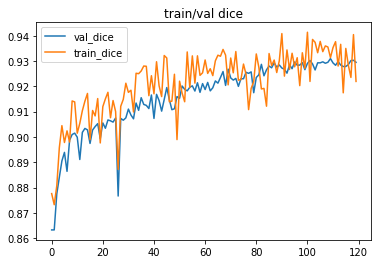

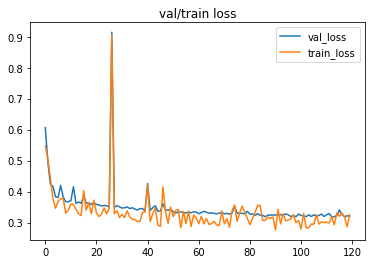

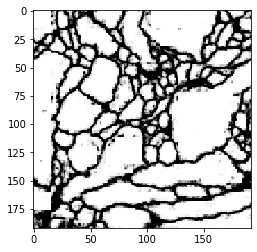

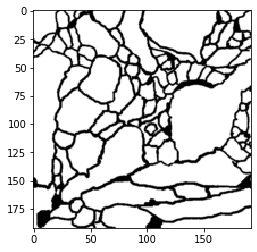

In [28]:
epochs=100

for i, _ in enumerate(range(epochs)):
    for batch in training_data_loader:
        X, y = process_batch(batch)
        prediction = model(X)  # [N, 2, H, W]
        loss = loss_bce(prediction, y)   
        optim.zero_grad()
        loss.backward()
        optim.step()   
        
    val_mean_dice, val_loss = evaluate(model, test_data_loader, threshold=THRESHOLD)
    train_mean_dice, train_loss = evaluate(model, train_ds_val_loader, threshold=THRESHOLD)
    
    print("epoch", i)
    print('dice', val_mean_dice)
    print('loss', val_loss)
    print('train_dice', train_mean_dice)
    print('train_loss', train_loss)
    model.train()
    
    history['val_dice'].append(val_mean_dice)
    history['val_loss'].append(val_loss)
    history['train_dice'].append(train_mean_dice)
    history['train_loss'].append(train_loss)
    
    

df = pd.DataFrame(history)

plt.figure()
plt.title('train/val dice')
plt.plot(df.val_dice)
plt.plot(df.train_dice)
plt.legend(['val_dice', 'train_dice'])
plt.figure()
plt.title('val/train loss')
plt.plot(df.val_loss)
plt.plot(df.train_loss)
plt.legend(['val_loss', 'train_loss'])


plt.figure()
plt.imshow(prediction[0][0].detach().sigmoid().cpu().numpy(), cmap='gray')
plt.figure()
plt.imshow(y.detach()[0][0].cpu().numpy(), cmap='gray')


In [29]:
import torch

In [30]:
torch

<module 'torch' from '/home/i008/anaconda3/envs/dl/lib/python3.7/site-packages/torch/__init__.py'>

In [31]:
!cat /home/i008/anaconda3/envs/dl/lib/python3.7/site-packages/torch/__init__.py

# @lint-ignore-every PYTHON3COMPATIMPORTS

r"""
The torch package contains data structures for multi-dimensional
tensors and mathematical operations over these are defined.
Additionally, it provides many utilities for efficient serializing of
Tensors and arbitrary types, and other useful utilities.

It has a CUDA counterpart, that enables you to run your tensor computations
on an NVIDIA GPU with compute capability >= 3.0.
"""

import os
import sys
import platform
from ._utils import _import_dotted_name
from ._utils_internal import get_file_path, prepare_multiprocessing_environment
from .version import __version__  # noqa: F401
from ._six import string_classes as _string_classes

__all__ = [
    'typename', 'is_tensor', 'is_storage', 'set_default_tensor_type',
    'set_rng_state', 'get_rng_state', 'manual_seed', 'initial_seed', 'seed',
    'save', 'load', 'set_printoptions', 'chunk', 'split', 'stack', 'matmul',
    'no_grad', 'enable_grad', 'rand', 'randn',
    'DoubleStorage', 'FloatSt